In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

In [31]:
model = load_model('./Model/mask_detection_best.h5')

In [32]:
batch_size = 16
validation_datagen = ImageDataGenerator(rescale = 1.0 / 255)
validation_generator = validation_datagen.flow_from_directory('./Data/val/',
                                                              target_size = (50, 50),
                                                              batch_size = batch_size,
                                                              shuffle = False)

Found 742 images belonging to 2 classes.


In [33]:
Y_pred = model.predict(validation_generator, 742 // batch_size + 1)
y_pred = np.where(Y_pred > .5, 1, 0)
print(confusion_matrix(validation_generator.classes, y_pred))

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())


print(classification_report(true_classes, y_pred, target_names=class_labels))

[[360  11]
 [  3 368]]
              precision    recall  f1-score   support

   with_mask       0.99      0.97      0.98       371
without_mask       0.97      0.99      0.98       371

    accuracy                           0.98       742
   macro avg       0.98      0.98      0.98       742
weighted avg       0.98      0.98      0.98       742



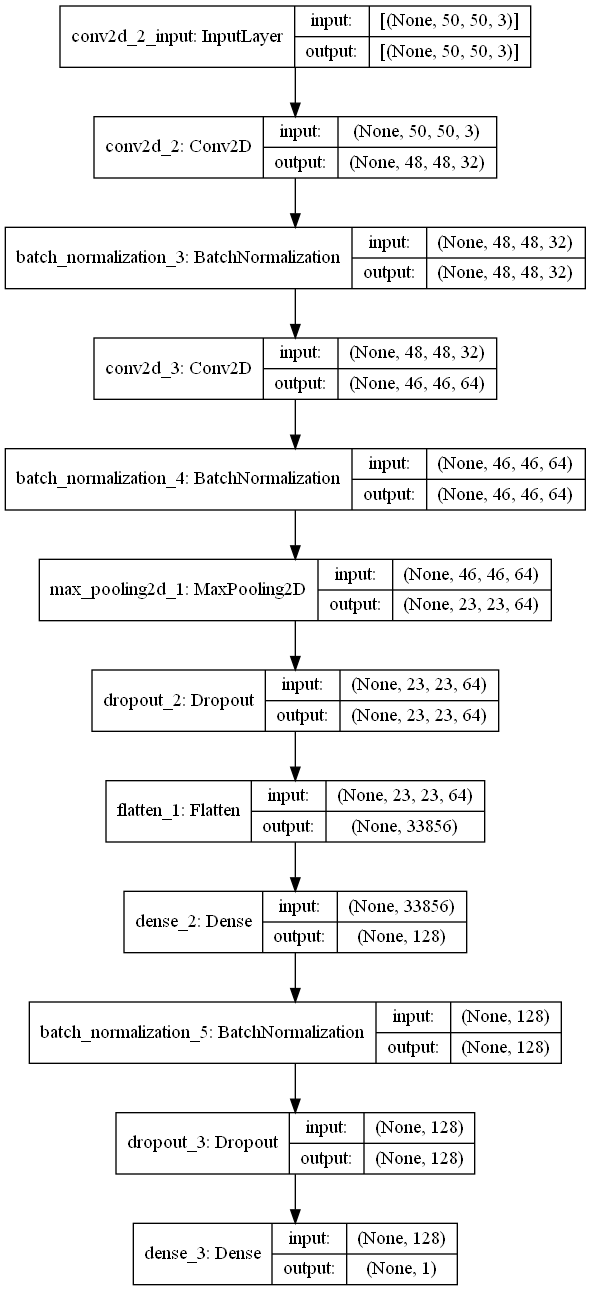

In [34]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='Model\model_plot.png',show_shapes=True,show_layer_names=True)